# Plot CSAPR2

In [4]:
import os
import warnings

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import pyart
from pyart.testing import get_test_data
import xradar as xd

warnings.filterwarnings('ignore')

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [152]:
file = "/data/project/ARM_Summer_School_2025/bnf/bnfcsapr2cfrS3.a1/bnfcsapr2cfrS3.a1.20250520.220020.nc"

In [148]:
files1 = sorted(glob.glob("/data/project/ARM_Summer_School_2025/bnf/bnfcsapr2cfrS3.a1/bnfcsapr2cfrS3.a1.20250520.22*"))
files2 = sorted(glob.glob("/data/project/ARM_Summer_School_2025/bnf/bnfcsapr2cfrS3.a1/bnfcsapr2cfrS3.a1.20250521.*"))

In [149]:
filelist = files1 + files2

In [140]:
file[-18:-3]

'20250520.220020'

In [141]:
outpath = "/data/home/kbritton/bnf-deep-convection/imgs/csapr_ppi/" + file[-18:-3] + '.jpg'

In [113]:
radar = pyart.io.read(file)

In [114]:
list(radar.fields.keys())

['attenuation_corrected_differential_reflectivity',
 'attenuation_corrected_differential_reflectivity_lag_1',
 'attenuation_corrected_reflectivity_h',
 'censor_mask',
 'classification_mask',
 'copol_correlation_coeff',
 'differential_phase',
 'differential_reflectivity',
 'differential_reflectivity_lag_1',
 'mean_doppler_velocity',
 'mean_doppler_velocity_v',
 'normalized_coherent_power',
 'normalized_coherent_power_v',
 'reflectivity',
 'reflectivity_v',
 'signal_to_noise_ratio_copolar_h',
 'signal_to_noise_ratio_copolar_v',
 'specific_differential_phase',
 'spectral_width',
 'spectral_width_v',
 'uncorrected_copol_correlation_coeff',
 'uncorrected_differential_phase',
 'uncorrected_differential_reflectivity',
 'uncorrected_differential_reflectivity_lag_1',
 'uncorrected_mean_doppler_velocity_h',
 'uncorrected_mean_doppler_velocity_v',
 'uncorrected_reflectivity_h',
 'uncorrected_reflectivity_v',
 'uncorrected_spectral_width_h',
 'uncorrected_spectral_width_v',
 'unthresholded_power_c

In [115]:
nyquist_velocity = radar.instrument_parameters["nyquist_velocity"]["data"]
nyquist_velocity
nyquist_value = np.unique(nyquist_velocity)[0]

In [116]:
vel_texture = pyart.retrieve.calculate_velocity_texture(radar,
                                                        vel_field='mean_doppler_velocity',
                                                        nyq=nyquist_value)
vel_texture

{'units': 'meters_per_second',
 'standard_name': 'texture_of_radial_velocity_of_scatters_away_from_instrument',
 'long_name': 'Doppler velocity texture',
 'coordinates': 'elevation azimuth range',
 'data': array([[1.90597636, 4.21606099, 4.61909816, ..., 8.30127196, 7.0220529 ,
         7.0220529 ],
        [2.02295807, 4.58419983, 4.66314623, ..., 7.91769374, 7.44214105,
         7.57185213],
        [2.02295807, 4.67402379, 4.67409454, ..., 7.44214105, 7.57185213,
         9.14783468],
        ...,
        [0.79154212, 0.6327803 , 0.5373353 , ..., 8.07379239, 8.07379239,
         8.0708598 ],
        [0.6327803 , 0.61212518, 0.57460472, ..., 9.50789107, 9.50789107,
         8.97771087],
        [0.57706446, 0.57706446, 0.60757789, ..., 9.84894029, 9.62004369,
         9.62004369]])}

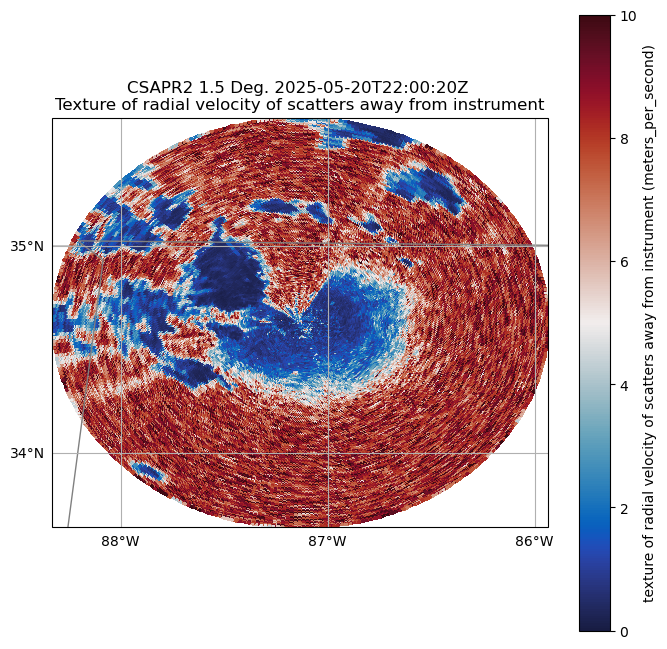

In [117]:
radar.add_field('texture', vel_texture, replace_existing=True)
fig = plt.figure(figsize=[8, 8])
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map('texture',
                     sweep=0,
                     resolution='50m',
                     vmin=0,
                     vmax=10, 
                     projection=ccrs.PlateCarree(),
                     cmap='balance')
plt.show()

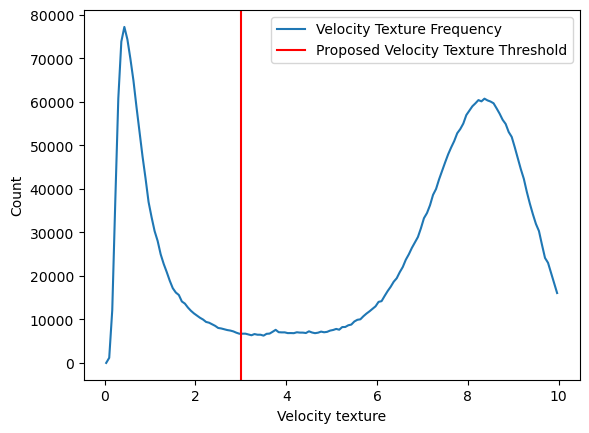

In [118]:
hist, bins = np.histogram(radar.fields['texture']['data'],
                          bins=150, range=(0,10))
bins = (bins[1:]+bins[:-1])/2.0

plt.plot(bins,
         hist,
         label='Velocity Texture Frequency')
plt.axvline(3,
            color='r',
            label='Proposed Velocity Texture Threshold')

plt.xlabel('Velocity texture')
plt.ylabel('Count')
plt.legend()

In [119]:
gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_above('texture', 4)

In [120]:
velocity_dealiased = pyart.correct.dealias_region_based(radar,
                                                        vel_field='mean_doppler_velocity',
                                                        nyquist_vel=nyquist_value,
                                                        centered=True,
                                                        gatefilter=gatefilter)

# Add our data dictionary to the radar object
radar.add_field('corrected_velocity', velocity_dealiased, replace_existing=True)

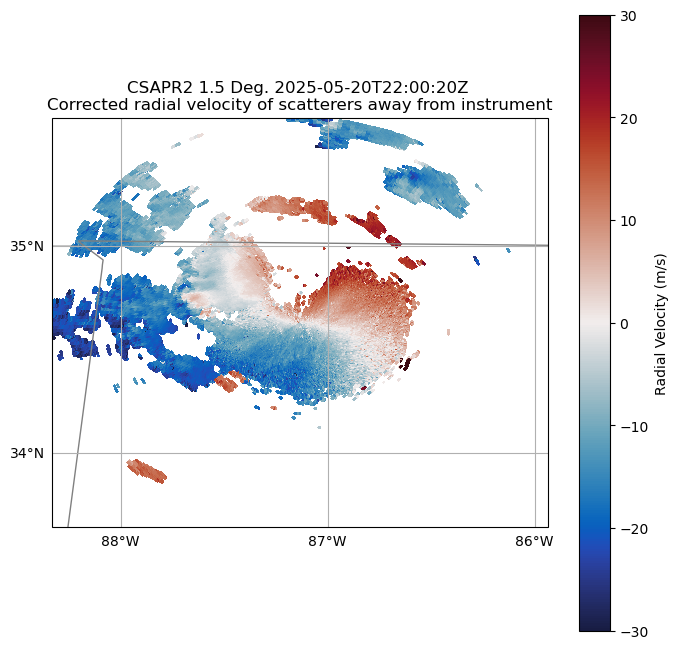

In [145]:
fig = plt.figure(figsize=[8, 8])
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map('corrected_velocity',
                     sweep=0,
                     resolution='50m',
                     vmin=-30,
                     vmax=30, 
                     projection=ccrs.PlateCarree(),
                     colorbar_label='Radial Velocity (m/s)',
                     cmap='balance',
                     gatefilter=gatefilter)
plt.show()

In [151]:

# loop thru files and plot reflectivity
for file in filelist:
    radar = pyart.io.read(file)
    outpath = "/data/home/kbritton/bnf-deep-convection/imgs/csapr_ppi/" + file[-18:-3] + '.jpg'
    # plot reflectivity
    fig = plt.figure(figsize=[8, 8])
    display = pyart.graph.RadarMapDisplay(radar)
    display.plot_ppi_map(('reflectivity'),
                     sweep=0,
                     resolution='50m',
                     vmin=-20,
                     vmax=60, 
                     projection=ccrs.PlateCarree(),
                     colorbar_label='',
                     cmap='Spectral_r',
                     gatefilter=gatefilter)

    #display.set_limits(xlim=(-87.5,-86.5),ylim=(34,35))
    #plt.show()
    plt.tight_layout()
    plt.savefig(outpath, dpi=150)
    plt.close()

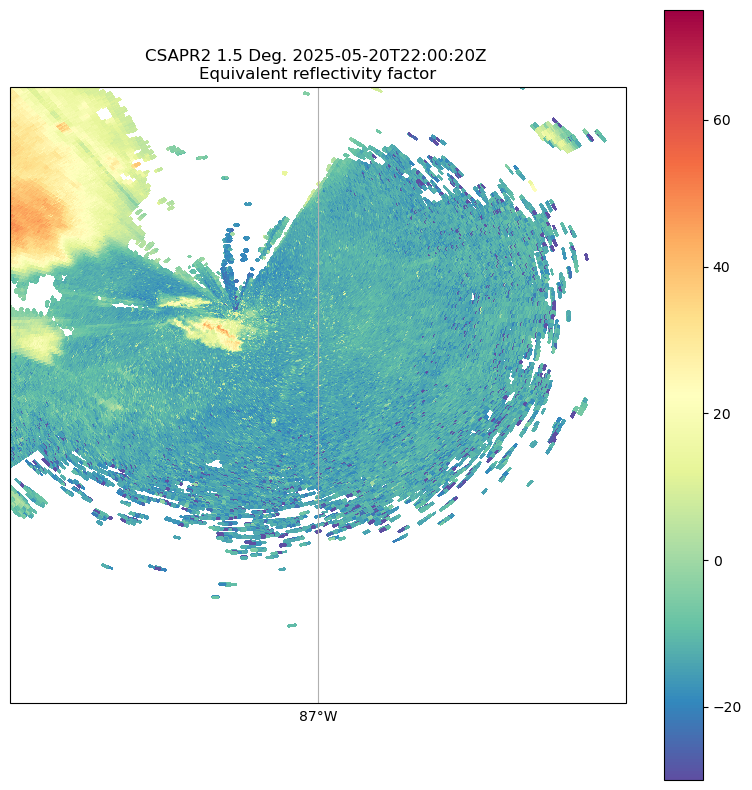

In [154]:
radar = pyart.io.read(file)
outpath = "/data/home/kbritton/bnf-deep-convection/imgs/csapr_ppi/" + file[-18:-3] + '.jpg'
# plot reflectivity
fig = plt.figure(figsize=[8, 8])
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map(('reflectivity'),
                     sweep=0,
                     resolution='50m',
                     #vmin=-20,
                     #vmax=60, 
                     projection=ccrs.PlateCarree(),
                     colorbar_label='',
                     cmap='Spectral_r',
                     gatefilter=gatefilter)

display.set_limits(xlim=(-87.5,-86.5),ylim=(34,35))
plt.tight_layout()
plt.show()


In [123]:
# gridding
z_grid_limits = (0.,15_000.)
y_grid_limits = (-60_000.,60_000.)
x_grid_limits = (-60_000.,60_000.)

grid_resolution = 500


In [124]:
def compute_number_of_points(extent, resolution):
    return int((extent[1] - extent[0])/resolution)

In [125]:
z_grid_points = compute_number_of_points(z_grid_limits, grid_resolution)
z_grid_points

30

In [126]:
x_grid_points = compute_number_of_points(x_grid_limits, grid_resolution)
y_grid_points = compute_number_of_points(y_grid_limits, grid_resolution)

print(z_grid_points,
      y_grid_points,
      x_grid_points)

30 240 240


In [127]:
grid = pyart.map.grid_from_radars([radar],
                                  grid_shape=(z_grid_points,
                                              y_grid_points,
                                              x_grid_points),
                                  grid_limits=(z_grid_limits,
                                               y_grid_limits,
                                               x_grid_limits),
                                 )
grid

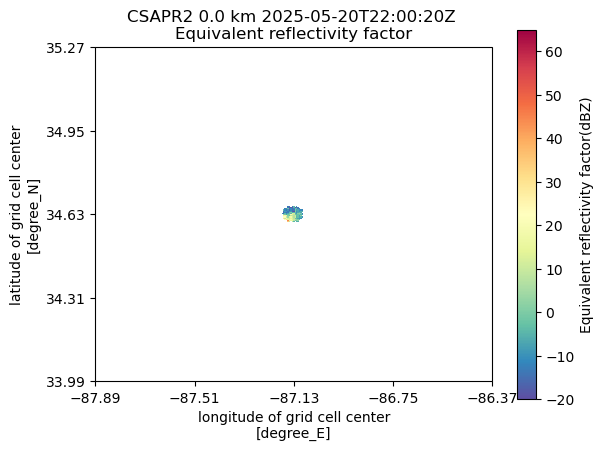

In [128]:
display = pyart.graph.GridMapDisplay(grid)
display.plot_grid('reflectivity',
                  level=0,
                  vmin=-20,
                  vmax=65,
                  cmap='Spectral_r'
                 )